In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install shap
!pip install bayesian-optimization
!pip install lightgbm
!pip install imblearn

     |████████████████████████████████| 266kB 4.6MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383186 sha256=d74ec128e53f624f567ca57d3845a2cf2b7df6993f894879165abb6df69b3514
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10031 sha256=4b62240b74dcf827b291d4cd767be50880e83dad72d281cbb336c1594ae5d694
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('/gdrive/My Drive/Data/train.csv', index_col=0)
test = pd.read_csv('/gdrive/My Drive/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/gdrive/My Drive/Data/sample_submission.csv', index_col=0)
scaler = MinMaxScaler()

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)

# train2 = train[["fiberID","type_num"]]
# train2["count"] =1
# train2_g = train2.groupby(["fiberID","type_num"]).count().unstack("type_num")
# train2_g.fillna(0,inplace=True)
# for i in range(train2_g.shape[0]):
#     for j in range(train2_g.shape[1]):
#         if train2_g.iloc[i,j]!="0":
#             train2_g.iloc[i,j] = str(1)
# 

# train_yk = train[["type_num","fiberID"]]
# train1 = train.drop(["type_num","fiberID"],axis=1)
# feature_col = train1.columns
# train_k = train1[train1[feature_col] < -2000]
# train_k1 = train1[train1[feature_col] > 1000]
# pre_index1 = set(train_k.dropna(how="all",axis=0).index)
# pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
# pre_index = list(pre_index1|pre_index2)
# train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
# train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
# train = pd.concat([train_yk,train1[feature_col]],axis=1)

In [0]:
train_x = train.drop(['type_num','fiberID'], axis=1)
train_y = train['type_num']
test_x = test.drop('fiberID',axis=1)
sc_col = train_x.iloc[:,:20].columns
not_col = train_x.columns.difference(sc_col)
tr_ind =  train_x.index
te_ind = test_x.index

In [88]:
train_x.iloc[train_x.petroMag_g.sort_values().index,:].head(10)

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
20678,25.213140,-335.608609,18.730224,17.492785,35.754727,17.592041,16.304712,17.210271,15.604834,15.334645,-203.458455,-1581.627834,17.445727,25.738032,-742.844861,26.231518,25.726196,17.654142,18.308034,24.927647
126586,25.421691,-7.776824,19.062686,19.383127,21.499947,19.963766,18.214195,17.474819,16.826398,17.753658,6.414558,-461.827987,15.780532,13.526510,62.539887,18.397928,8.686690,15.223118,13.818629,17.362915
120394,19.829570,13.164483,-49.454334,17.221968,17.387468,18.780283,16.680690,16.441336,16.544852,15.378526,21.740577,-428.243687,-776.113687,16.722622,15.767410,20.254960,24.676874,26.197795,16.882742,17.050897
15075,23.440811,21.968284,20.369307,20.323648,19.916692,22.509966,21.530021,20.811595,19.942091,19.563019,25.814685,-360.107710,17.897214,19.326991,19.921201,24.778793,21.524778,20.170892,19.715189,19.517240
99558,18.685075,24.714002,18.467603,17.774454,18.430559,22.510353,20.214351,19.772446,17.939147,19.311684,39.436954,-261.655610,30.660711,20.295036,25.712890,24.090960,20.644793,18.831541,18.159081,17.728447
122123,24.730024,14.297044,19.248314,18.086121,12.332252,19.889020,17.948195,16.667930,16.563354,16.611364,113.765297,-246.652171,18.625917,14.381233,177.386293,27.324279,40.136284,15.184361,13.323987,22.732314
120721,19.209516,41.106205,-22.442654,30.262485,21.373743,19.316379,17.759567,17.002050,16.634297,16.255971,16.390705,-243.879956,541.973213,-654.195115,17.171924,16.377194,27.280624,5.781584,5.004407,17.977208
199884,22.134689,22.353435,21.823706,22.051016,20.945543,23.075033,22.663621,22.023074,22.282470,22.389535,22.008371,-198.876440,20.715873,30.637097,16.820650,22.606168,22.328662,21.875243,21.826708,21.309713
166546,21.891289,18.997955,17.569091,16.991365,16.656593,20.077808,18.109054,17.197551,16.705674,16.323136,19.193590,-180.983003,15.229065,14.541938,-39.463198,19.537448,17.660086,15.603739,15.138014,14.918205
142735,9.330252,22.921731,19.879210,19.835447,24.359650,21.556501,18.682697,18.110696,16.650041,17.769212,-602.308328,-166.981947,14.764800,16.224679,59.900113,19.484154,28.454348,16.685642,16.419943,27.657622


In [91]:
train_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [110]:
train_x = train_x.drop([93828,47032,133359,120394,120721,120339,35853],axis=0).reset_index(drop=True)
train_y = train_y.drop([93828,47032,133359,120394,120721,120339,35853]).reset_index(drop=True)
test_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.462021,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,13.971203,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-1348.068776,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


In [0]:
set_d = pd.concat([train_x,test_x],axis=0)
set_data = pd.DataFrame()
for i in sc_col:
  # set_data[i] = 1/set_d[i]
  set_data[i] = set_d[i]-set_d[i].min()+2
    #set_data[i] = set_d[i]-set_d[i].min()+10
#train_x1 = np.log(train_x1)
#test_x1 = np.log(test_x1)

In [115]:
train_x.shape

(199953, 20)

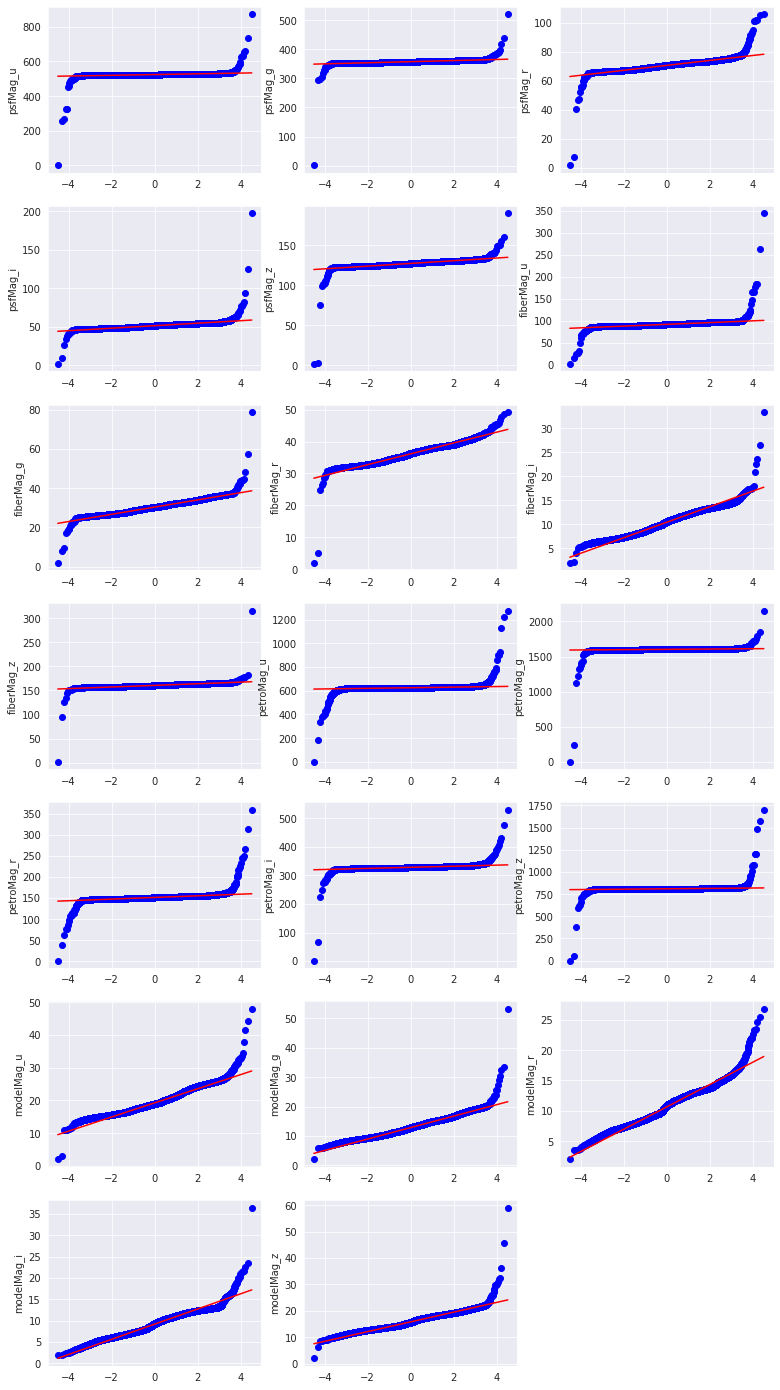

In [113]:
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
for i, col in enumerate(sc_col):
    plt.subplot(7,3,i+1)
    sp.stats.probplot(set_data.iloc[:,i], plot=plt)
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

psfMag_u  optimal lambda: 1.8367481941413635
psfMag_g  optimal lambda: 2.2854277846574504
psfMag_r  optimal lambda: 1.8724964146905856
psfMag_i  optimal lambda: 0.5623038591650843
psfMag_z  optimal lambda: 2.4870902058971125
fiberMag_u  optimal lambda: 0.5549304696848151
fiberMag_g  optimal lambda: 0.8281392214297159
fiberMag_r  optimal lambda: 1.8211244010825287
fiberMag_i  optimal lambda: 1.0675302531956612
fiberMag_z  optimal lambda: 1.3150123649361434
petroMag_u  optimal lambda: 1.0852922549376671
petroMag_g  optimal lambda: 3.691062133492725
petroMag_r  optimal lambda: 0.8989908864783505
petroMag_i  optimal lambda: 1.868728639396125
petroMag_z  optimal lambda: 1.1248711649717478
modelMag_u  optimal lambda: -0.38990362909391707
modelMag_g  optimal lambda: 0.47248002201334777
modelMag_r  optimal lambda: 0.8656239243144633
modelMag_i  optimal lambda: 0.8239339484593774
modelMag_z  optimal lambda: 0.26949817645364016


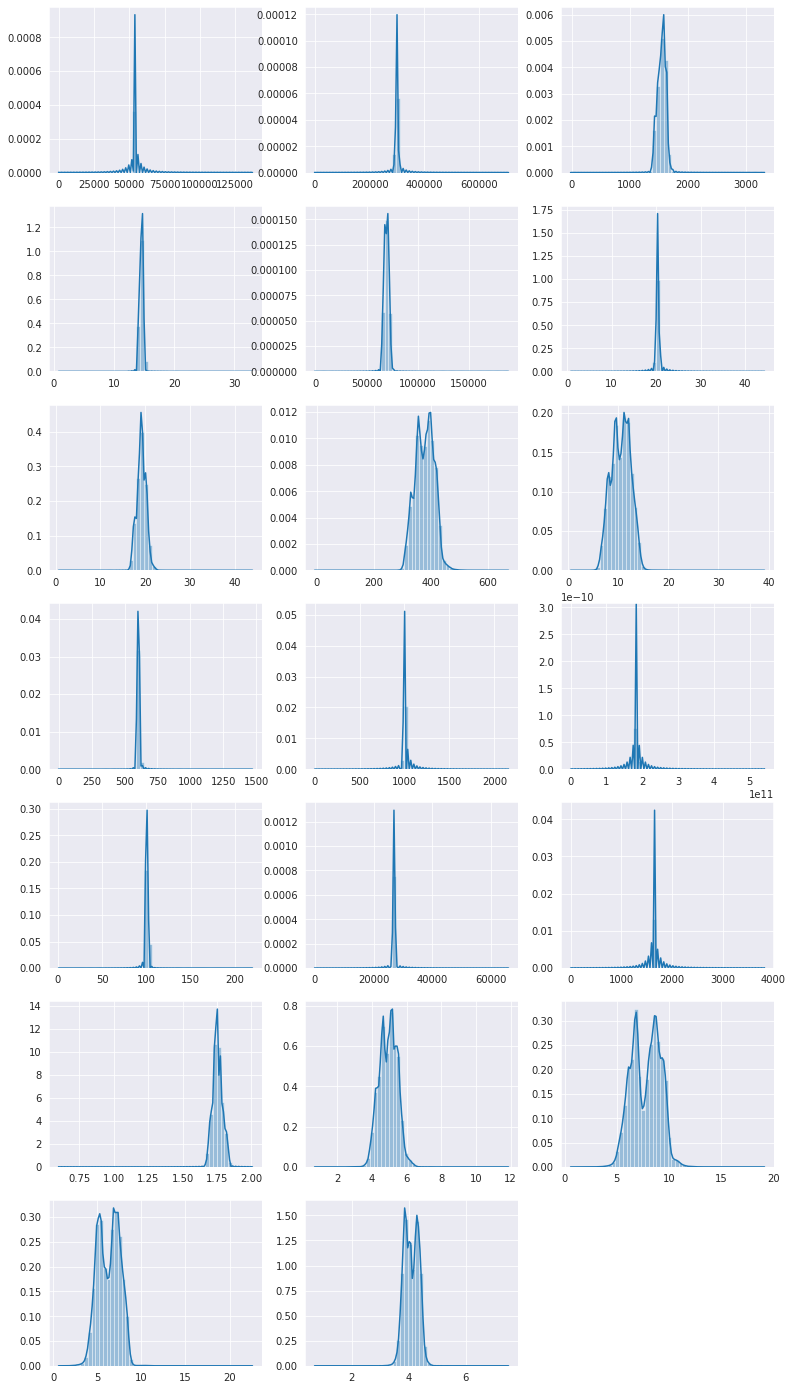

In [116]:
import scipy as sp
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
lambda_list = []
train_box = pd.DataFrame()
for i,col in enumerate(sc_col):
  ax1 = plt.subplot(7,3,i+1)
  #x, y = sp.stats.boxcox_normplot(train_x1.iloc[:,i], -2, 2)
  #plt.plot(x, y);
  y2, l = sp.stats.boxcox(set_data.iloc[:,i])
  train_box[col] = y2
  sns.distplot(y2, ax=ax1)
  #plt.axvline(x=l, color='r', ls="--");
  print(col ," optimal lambda:", l)
  lambda_list.append(l)

In [0]:
set_d = pd.concat([train_x,test_x],axis=0)
set_data = pd.DataFrame()
for i in sc_col:
  # set_data[i] = 1/set_d[i]
  set_data[i] = set_data[i]-set_data[i].min()+2
#train_x1 = np.log(train_x1)
#test_x1 = np.log(test_x1)

In [0]:
test_box = train_box.iloc[199953:,:]
train_box = train_box.iloc[:199953,:]

In [122]:
test_box.shape

199953

In [0]:
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()
train_x_sc = scaler.fit_transform(train_box[sc_col])
test_x_sc = scaler.transform(test_box[sc_col])
train_x_sc =  pd.DataFrame(train_x_sc,columns = sc_col,index = train_box.index)
test_x_sc =  pd.DataFrame(test_x_sc,columns = sc_col,index = test_box.index)

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_x_sc, train_y):
    x_train, y_train = train_x_sc.loc[train_index], train_y[train_index]
    x_val, y_val = train_x_sc.loc[test_index] , train_y[test_index]

In [123]:
import lightgbm as lgb
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=60, max_depth=-1, learning_rate=0.003, 
                             n_estimators=3000, subsample_for_bin=400000, objective='multiclass', min_split_gain=0.15, reg_alpha = 0.1, 
                             min_child_weight=5e-3, min_child_samples=10,n_jobs=-1, random_state=42,)
lgb_model1 = lgb_clf1.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds.
[200]	valid_0's multi_logloss: 0.949586
[400]	valid_0's multi_logloss: 0.624867
[600]	valid_0's multi_logloss: 0.500049
[800]	valid_0's multi_logloss: 0.445745
[1000]	valid_0's multi_logloss: 0.419141
[1200]	valid_0's multi_logloss: 0.405419
[1400]	valid_0's multi_logloss: 0.397541
[1600]	valid_0's multi_logloss: 0.392596
[1800]	valid_0's multi_logloss: 0.389197
[2000]	valid_0's multi_logloss: 0.386775
[2200]	valid_0's multi_logloss: 0.384976
[2400]	valid_0's multi_logloss: 0.38363
[2600]	valid_0's multi_logloss: 0.382633
[2800]	valid_0's multi_logloss: 0.381688
[3000]	valid_0's multi_logloss: 0.380856
Did not meet early stopping. Best iteration is:
[3000]	valid_0's multi_logloss: 0.380856


In [107]:
lgb_model1.learning_rate = 0.002
lgb_model1.n_estimators = 1000
lgb_model1.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=100, verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 1.7373
[200]	valid_0's multi_logloss: 1.43425
[300]	valid_0's multi_logloss: 1.22476
[400]	valid_0's multi_logloss: 1.0692


KeyboardInterrupt: ignored

In [0]:
y_test = lgb_model1.predict_proba(test_x_sc)
submission = pd.DataFrame(data=y_test, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('/gdrive/My Drive/Data/submission1.csv', index=True)